In [ ]:
# for reference = DONT RUN
t_hist_slice = t_hist.sel(time=slice('1950-01-01', '2000-12-31'), lat=slice(10,60), lon=slice(260,360))
t_hist_2p5m = t_hist_slice.sel(lev=2.5)
t_hist_2500m = t_hist_slice.sel(lev=2500)
t_fut_slice = t_fut.sel(time=slice('2050-01-01', '2100-12-31'), lat=slice(10,60), lon=slice(260,360))
t_fut_2p5m = t_fut_slice.sel(lev=2.5)
t_fut_2500m = t_fut_slice.sel(lev=2500)

In [14]:
# RUN THIS [1]
# Start by importing our modules
import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

import warnings 
warnings.filterwarnings("ignore")

In [15]:
# RUN THIS [2]
# Load the historical model output dataset
ds_hist = xr.open_mfdataset('../shared-datasets/thetao_hist/*.nc')

# load the future model output data set
ds_fut = xr.open_mfdataset('../shared-datasets/thetao_fut/*.nc')

t_hist = ds_hist.thetao
t_fut = ds_fut.thetao

t_hist_2p5m = xr.open_dataset('t_hist_2p5m.nc').thetao
t_hist_2500m = xr.open_dataset('t_hist_2500m.nc').thetao

t_fut_2p5m = xr.open_dataset('t_fut_2p5m.nc').thetao
t_fut_2500m = xr.open_dataset('t_fut_2500m.nc').thetao

__________________________________________________________________________________________________________________________________

## Task 2
For the same two time periods, produce 2-dimensional (latitude-longitude) maps showing the difference in time-mean temperature, indicating where this difference is statistically significant with respect to the inter-annual (annual mean) variability.

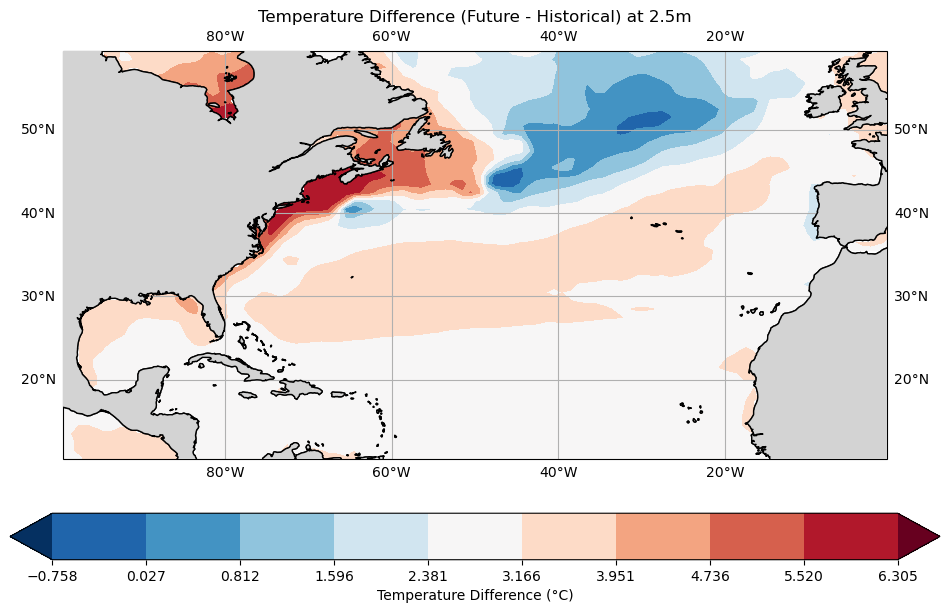

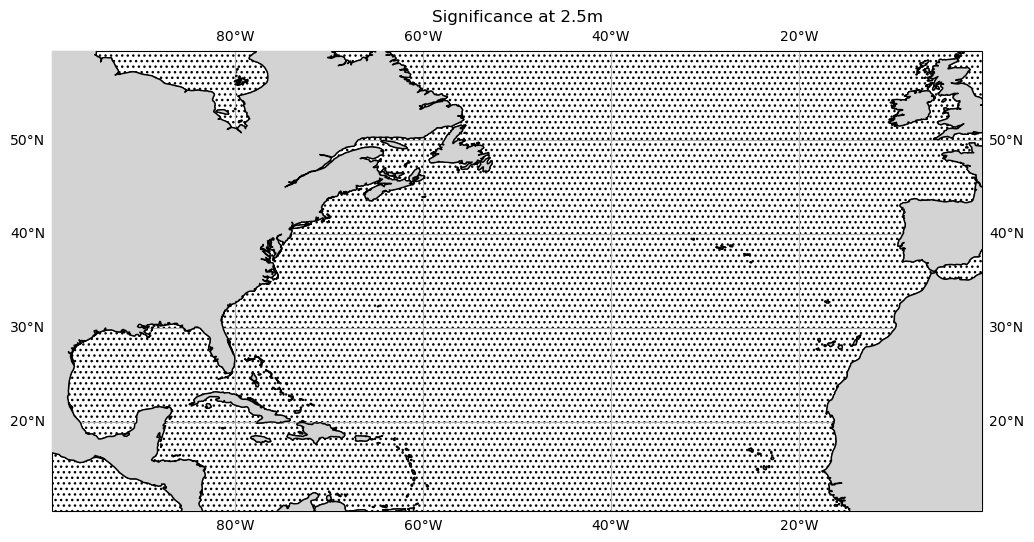

In [16]:
# Compute time-mean temperatures
t_hist_mean_2p5m = t_hist_2p5m.mean(dim='time')
t_hist_mean_2500m = t_hist_2500m.mean(dim='time')
t_fut_mean_2p5m = t_fut_2p5m.mean(dim='time')
t_fut_mean_2500m = t_fut_2p5m.mean(dim='time')

# Compute temperature differences
diff_mean_2p5m = t_fut_mean_2p5m - t_hist_mean_2p5m
diff_mean_2500m = t_fut_mean_2500m - t_hist_mean_2500m

# Compute inter-annual variability
hist_var_2p5m = t_hist_2p5m.groupby('time.year').mean(dim='time').std(dim='year')
fut_var_2p5m = t_fut_2p5m.groupby('time.year').mean(dim='time').std(dim='year')
hist_var_2500m = t_hist_2500m.groupby('time.year').mean(dim='time').std(dim='year')
fut_var_2500m = t_fut_2p5m.groupby('time.year').mean(dim='time').std(dim='year')

# Statistical significance using t-test
t_stat_2p5m, p_value_2p5m = stats.ttest_ind_from_stats(
    mean1=t_hist_mean_2p5m, std1=hist_var_2p5m, nobs1=t_hist_2p5m.sizes['time'],
    mean2=t_fut_mean_2p5m, std2=fut_var_2p5m, nobs2=t_fut_2p5m.sizes['time']
)
t_stat_2500m, p_value_2500m = stats.ttest_ind_from_stats(
    mean1=t_hist_mean_2500m, std1=hist_var_2500m, nobs1=t_hist_2500m.sizes['time'],
    mean2=t_fut_mean_2500m, std2=fut_var_2500m, nobs2=t_fut_2500m.sizes['time']
)

# Create significance masks
sig_mask_2p5m = p_value_2p5m < 0.05
sig_mask_2500m = p_value_2500m < 0.05

# Define the plot function
def plot_temp_diff_and_sig_2p5m(t_hist_2p5m, t_fut_2p5m, sig_mask):
    """Create separate plots for temperature differences and significance at 2.5m."""
    
    # Calculate time means
    hist_mean = t_hist_2p5m.mean('time')
    fut_mean = t_fut_2p5m.mean('time')
    temp_diff = fut_mean - hist_mean
    
    # Determine min and max temperature differences
    vmin = temp_diff.min().values
    vmax = temp_diff.max().values
    
    # Create figures for temperature difference
    fig1 = plt.figure(figsize=(12, 8))
    ax1 = plt.axes(projection=ccrs.PlateCarree())
    
    levels = np.linspace(vmin, vmax, 10)  # Adjust range to min and max values
    cf = temp_diff.plot.contourf(
        ax=ax1,
        levels=levels,
        extend='both',
        cmap='RdBu_r',
        transform=ccrs.PlateCarree(),
        add_colorbar=False
    )
    
    # Add coastlines and grid
    ax1.coastlines()
    ax1.gridlines(draw_labels=True)
    ax1.add_feature(cfeature.LAND, zorder=100, edgecolor='k', facecolor='lightgray')
    
    # Add title
    title_diff = 'Temperature Difference (Future - Historical) at 2.5m'
    plt.title(title_diff)
    
    # Add colorbar
    plt.subplots_adjust(bottom=0.2)
    cbar = plt.colorbar(cf, orientation='horizontal', extend='both', ax=ax1, pad=0.1)
    cbar.set_label('Temperature Difference (°C)')
    
    # Show plot
    plt.show()
    
    # Create figures for significance
    fig2 = plt.figure(figsize=(12, 8))
    ax2 = plt.axes(projection=ccrs.PlateCarree())
    
    # Plot significance with hatching
    lon2d, lat2d = np.meshgrid(temp_diff.lon, temp_diff.lat)
    ax2.contourf(lon2d, lat2d, sig_mask, colors='none',
                 hatches=['...' if sig else '' for sig in sig_mask.flatten()],
                 transform=ccrs.PlateCarree())
    
    # Add coastlines and grid
    ax2.coastlines()
    ax2.gridlines(draw_labels=True)
    ax2.add_feature(cfeature.LAND, zorder=100, edgecolor='k', facecolor='lightgray')
    
    # Add title
    title_sig = 'Significance at 2.5m'
    plt.title(title_sig)

    # Show plot
    plt.show()

# Display temperature difference and significance plots for 2.5m
plot_temp_diff_and_sig_2p5m(t_hist_2p5m, t_fut_2p5m, sig_mask_2p5m)


**Figure 1:** Top - Temperature Difference (Future - Historical) at 2.5m. Mean temperature difference at 2.5 meters in the North Atlantic Ocean between 2050-2100 and 1950-2000 ranges from -0.758°C to 6.305°C, with blue for cooler areas and red for warmer regions.
Bottom - Statistical Significance of Temperature Differences at 2.5m. Stippling patterns indicate significant temperature differences between future (2050-2100) and historical (1950-2000) periods at 2.5 meters at the 95% confidence level, covering the North Atlantic, parts of North America, and Europe 

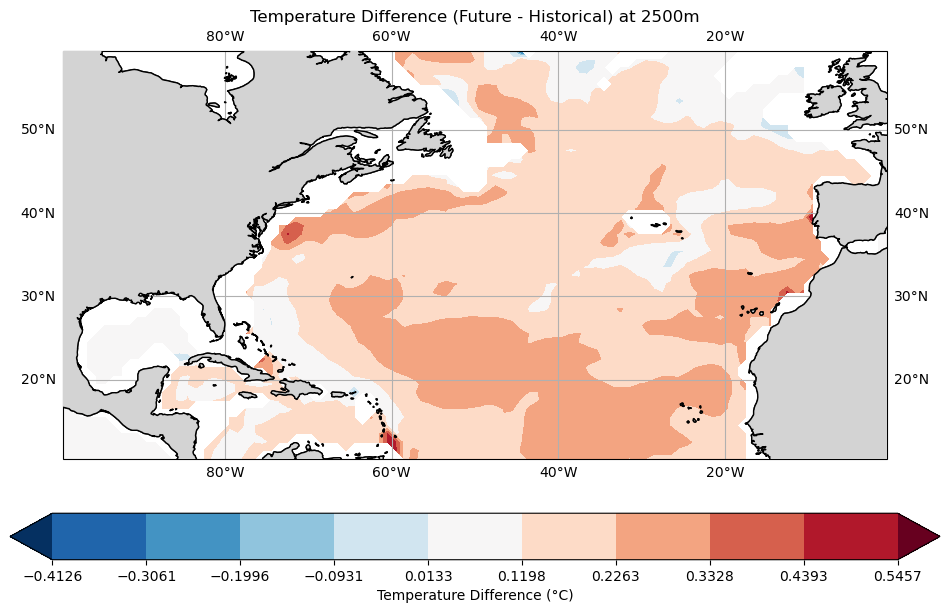

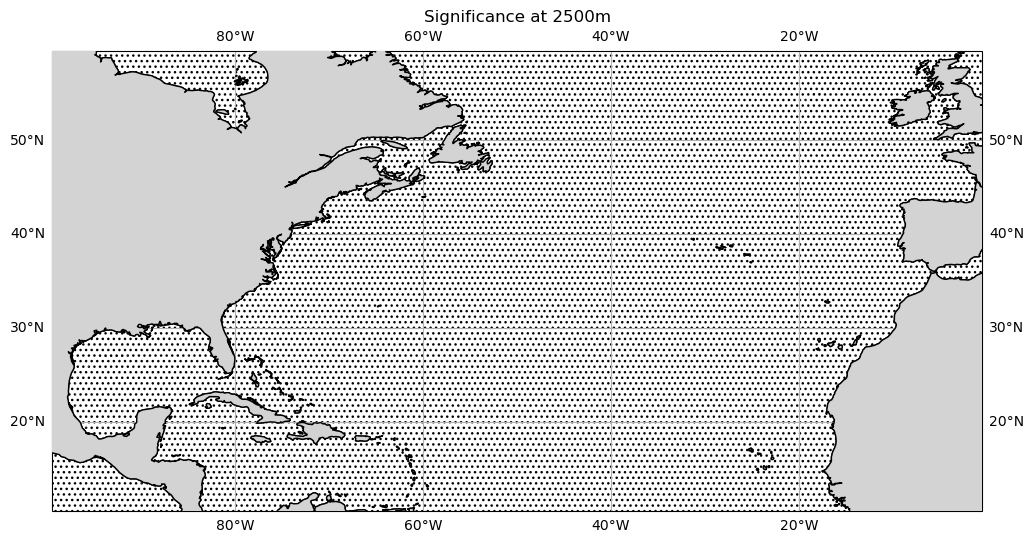

In [17]:
# Compute time-mean temperatures
t_hist_mean_2500m = t_hist_2500m.mean(dim='time')
t_fut_mean_2500m = t_fut_2500m.mean(dim='time')

# Compute temperature differences
diff_mean_2500m = t_fut_mean_2500m - t_hist_mean_2500m

# Compute inter-annual variability
hist_var_2500m = t_hist_2500m.groupby('time.year').mean(dim='time').std(dim='year')
fut_var_2500m = t_fut_2500m.groupby('time.year').mean(dim='time').std(dim='year')

# Statistical significance using t-test
t_stat_2500m, p_value_2500m = stats.ttest_ind_from_stats(
    mean1=t_hist_mean_2500m, std1=hist_var_2500m, nobs1=t_hist_2500m.sizes['time'],
    mean2=t_fut_mean_2500m, std2=fut_var_2500m, nobs2=t_fut_2500m.sizes['time']
)

# Create significance masks
sig_mask_2500m = p_value_2500m < 0.05

# Define the plot function
def plot_temp_diff_and_sig_2500m(t_hist_2500m, t_fut_2500m, sig_mask):
    """Create separate plots for temperature differences and significance at 2500m."""
    
    # Calculate time means
    hist_mean = t_hist_2500m.mean('time')
    fut_mean = t_fut_2500m.mean('time')
    temp_diff = fut_mean - hist_mean
    
    # Determine min and max temperature differences
    vmin = temp_diff.min().values
    vmax = temp_diff.max().values
    
    # Create figures for temperature difference
    fig1 = plt.figure(figsize=(12, 8))
    ax1 = plt.axes(projection=ccrs.PlateCarree())
    
    levels = np.linspace(vmin, vmax, 10)  # Adjust range to min and max values
    cf = temp_diff.plot.contourf(
        ax=ax1,
        levels=levels,
        extend='both',
        cmap='RdBu_r',
        transform=ccrs.PlateCarree(),
        add_colorbar=False
    )
    
    # Add coastlines and grid
    ax1.coastlines()
    ax1.gridlines(draw_labels=True)
    ax1.add_feature(cfeature.LAND, zorder=100, edgecolor='k', facecolor='lightgray')
    
    # Add title
    title_diff = 'Temperature Difference (Future - Historical) at 2500m'
    plt.title(title_diff)
    
    # Add colorbar
    plt.subplots_adjust(bottom=0.2)
    cbar = plt.colorbar(cf, orientation='horizontal', extend='both', ax=ax1, pad=0.1)
    cbar.set_label('Temperature Difference (°C)')
    
    # Show plot
    plt.show()
    
    # Create figures for significance
    fig2 = plt.figure(figsize=(12, 8))
    ax2 = plt.axes(projection=ccrs.PlateCarree())
    
    # Plot significance with hatching
    lon2d, lat2d = np.meshgrid(temp_diff.lon, temp_diff.lat)
    ax2.contourf(lon2d, lat2d, sig_mask, colors='none',
                 hatches=['...' if sig else '' for sig in sig_mask.flatten()],
                 transform=ccrs.PlateCarree())
    
    # Add coastlines and grid
    ax2.coastlines()
    ax2.gridlines(draw_labels=True)
    ax2.add_feature(cfeature.LAND, zorder=100, edgecolor='k', facecolor='lightgray')
    
    # Add title
    title_sig = 'Significance at 2500m'
    plt.title(title_sig)

    # Show plot
    plt.show()

# Display temperature difference and significance plots for 2500m
plot_temp_diff_and_sig_2500m(t_hist_2500m, t_fut_2500m, sig_mask_2500m)


**Figure 2:** Top - Temperature Difference (Future - Historical) at 2500m. Mean temperature difference at 2500 meters in the North Atlantic Ocean between 2050-2100 and 1950-2000 ranges from -0.4126°C to 0.5457°C, with blue for cooler areas and red for warmer regions.
Bottom - Statistical Significance of Temperature Differences at 2500m. Stippling patterns indicate significant temperature differences between future (2050-2100) and historical (1950-2000) periods at 2500 meters at the 95% confidence level, covering the North Atlantic, parts of North America, and Europe

## **Results**
The analysis of temperature variations in the North Atlantic Ocean at depths of 2.5 meters and 2500 meters reveals distinct patterns of change. Statistically significant warming has been observed at 2.5m, with recorded temperature increases of 6.31°C along the eastern coast of North America. However, certain regions exhibited statistically significant cooling, with decreases of -0.76°C. At 2500m, temperatures showed uniform warming trends in the North Atlantic, peaking at 0.54°C.
The shallow waters (2.5 meters) demonstrated more pronounced and diverse temperature fluctuations, featuring both warming and cooling regions. In contrast, the deep waters (2500 meters) exhibited a consistent warming pattern. The notable variations observed at shallower depths could have significant ecological implications, whereas the gradual warming of the deep ocean may affect long-term oceanic circulation and climate patterns.

## **Addressing Task 2**
Spatial Visualization:
2D (latitude-longitude) maps show areas with pronounced temperature differences, aiding in understanding the spatial distribution of climate change impacts at various depths.
Significance of Changes:
The analysis assesses regions with significant temperature differences, revealing areas where observed climatic changes are primarily linked to climate change rather than natural variability.
Depth Comparison:
Analyzing temperatures at 2.5 and 2500 meters separately enabled comparing changes in near-surface and deeper ocean layers.